# Use OffPAC to Play Acrobot-v1

TensorFlow version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras
from tensorflow import nn
from tensorflow import optimizers
from tensorflow.keras import layers
from tensorflow.keras import losses

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

19:57:00 [INFO] env: <AcrobotEnv<Acrobot-v1>>
19:57:00 [INFO] action_space: Discrete(3)
19:57:00 [INFO] observation_space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
19:57:00 [INFO] reward_range: (-inf, inf)
19:57:00 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
19:57:00 [INFO] _max_episode_steps: 500
19:57:00 [INFO] _elapsed_steps: None


In [3]:
class OffPACAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99
        
        self.actor_net = self.build_net(hidden_sizes=[100,],
                output_size=self.action_n,
                output_activation=nn.softmax, learning_rate=0.0002)
        self.critic_net = self.build_net(hidden_sizes=[100,],
                output_size=self.action_n,
                learning_rate=0.0004)

    def build_net(self, hidden_sizes, output_size, 
                activation=nn.relu, output_activation=None,
                loss=losses.mse, learning_rate=0.001):
        model = keras.Sequential()
        for hidden_size in hidden_sizes:
            model.add(layers.Dense(units=hidden_size,
                    activation=activation))
        model.add(layers.Dense(units=output_size,
                activation=output_activation))
        optimizer = optimizers.SGD(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.discount = 1.

    def step(self, observation, reward, done):
        if self.mode == 'train':
            action = np.random.choice(self.action_n)
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                self.learn()
            self.discount *= self.gamma
        else:
            probs = self.actor_net.predict(observation[np.newaxis])[0]
            action = np.random.choice(self.action_n, p=probs)
        return action

    def close(self):
        pass
    
    def learn(self):
        state, _, _, action, next_state, reward, done, next_action = \
                self.trajectory[-8:]
        behavior_prob = 1. / self.action_n
        pi = self.actor_net.predict(state[np.newaxis])[0, action]
        ratio = pi / behavior_prob # importance sampling ratio

        # train actor
        q = self.critic_net.predict(state[np.newaxis])[0, action]
        state_tensor = tf.convert_to_tensor(state[np.newaxis], dtype=tf.float32)
        with tf.GradientTape() as tape:
            pi_tensor = self.actor_net(state_tensor)[0, action]
            actor_loss_tensor = -self.discount * q / behavior_prob * pi_tensor
        grad_tensors = tape.gradient(actor_loss_tensor, self.actor_net.variables)
        self.actor_net.optimizer.apply_gradients(zip(grad_tensors,
                self.actor_net.variables))
        
        # train critic
        next_q = self.critic_net.predict(next_state[np.newaxis])[0, next_action]
        target = reward + (1. - done) * self.gamma * next_q
        target_tensor = tf.convert_to_tensor(target, dtype=tf.float32)
        with tf.GradientTape() as tape:
            q_tensor = self.critic_net(state_tensor)
            mse_tensor = losses.MSE(target_tensor, q_tensor)
            critic_loss_tensor = ratio * mse_tensor
        grad_tensors = tape.gradient(critic_loss_tensor, self.critic_net.variables)
        self.critic_net.optimizer.apply_gradients(zip(grad_tensors,
                self.critic_net.variables))


agent = OffPACAgent(env)

19:57:01 [INFO] ==== train & verify ====
20:00:48 [DEBUG] verify episode 0: reward = -500.00, steps = 500
20:04:17 [DEBUG] verify episode 1: reward = -321.00, steps = 322
20:07:49 [DEBUG] verify episode 2: reward = -329.00, steps = 330
20:11:13 [DEBUG] verify episode 3: reward = -275.00, steps = 276
20:14:49 [DEBUG] verify episode 4: reward = -256.00, steps = 257
20:19:41 [DEBUG] verify episode 5: reward = -440.00, steps = 441
20:23:54 [DEBUG] verify episode 6: reward = -307.00, steps = 308
20:28:46 [DEBUG] verify episode 7: reward = -267.00, steps = 268
20:33:15 [DEBUG] verify episode 8: reward = -221.00, steps = 222
20:37:46 [DEBUG] verify episode 9: reward = -188.00, steps = 189
20:42:54 [DEBUG] verify episode 10: reward = -500.00, steps = 500
20:47:11 [DEBUG] verify episode 11: reward = -200.00, steps = 201
20:52:08 [DEBUG] verify episode 12: reward = -500.00, steps = 500
20:57:07 [DEBUG] verify episode 13: reward = -500.00, steps = 500
21:02:21 [DEBUG] verify episode 14: reward = 

22:55:22 [DEBUG] test episode 92: reward = -169.00, steps = 170
22:55:41 [DEBUG] test episode 93: reward = -85.00, steps = 86
22:56:03 [DEBUG] test episode 94: reward = -91.00, steps = 92
22:56:31 [DEBUG] test episode 95: reward = -111.00, steps = 112
22:57:00 [DEBUG] test episode 96: reward = -109.00, steps = 110
22:57:24 [DEBUG] test episode 97: reward = -89.00, steps = 90
22:57:45 [DEBUG] test episode 98: reward = -86.00, steps = 87
22:58:02 [DEBUG] test episode 99: reward = -71.00, steps = 72
22:58:02 [INFO] average episode reward = -107.07 ± 25.88


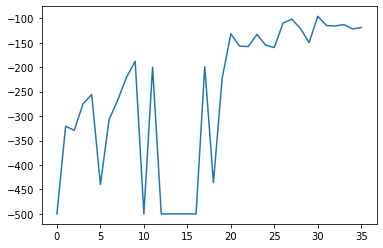

In [4]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train & verify ====')
episode_rewards = []
for episode in itertools.count():
    play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('verify episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()